In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# Load the dataset
dataset = load_dataset("poem_sentiment")

# Tokenize the dataset
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["verse_text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Split the dataset into train and test sets
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
test_dataset = tokenized_datasets["test"].shuffle(seed=42)

# Check class distribution
class_distribution = Counter(train_dataset["label"])
print("Class Distribution in Train Dataset:", class_distribution)

# Balance the dataset using oversampling
train_texts = train_dataset["verse_text"]
train_labels = train_dataset["label"]
train_texts = np.array(train_texts).reshape(-1, 1)

oversampler = RandomOverSampler(random_state=42)
train_texts_balanced, train_labels_balanced = oversampler.fit_resample(train_texts, train_labels)
train_texts_balanced = train_texts_balanced.flatten()

# Create a new balanced dataset
balanced_train_dataset = Dataset.from_dict({"verse_text": train_texts_balanced, "label": train_labels_balanced})
tokenized_train_dataset = balanced_train_dataset.map(tokenize_function, batched=True)
tokenized_train_dataset = tokenized_train_dataset.shuffle(seed=42)

# Verify class distribution
balanced_class_distribution = Counter(tokenized_train_dataset["label"])
print("Class Distribution in Balanced Train Dataset:", balanced_class_distribution)

# Load RoBERTa model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,  # Add compute_metrics function
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print("RoBERTa Evaluation Results:", results)

# Predict on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)


Class Distribution in Train Dataset: Counter({2: 555, 0: 155, 1: 133, 3: 49})


Map:   0%|          | 0/2220 [00:00<?, ? examples/s]

Class Distribution in Balanced Train Dataset: Counter({3: 555, 1: 555, 0: 555, 2: 555})


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Rahul\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/417 [00:00<?, ?it/s]

{'loss': 1.3886, 'grad_norm': 2.81710147857666, 'learning_rate': 1.9520383693045567e-05, 'epoch': 0.07}
{'loss': 1.3927, 'grad_norm': 3.241586923599243, 'learning_rate': 1.9040767386091128e-05, 'epoch': 0.14}
{'loss': 1.3982, 'grad_norm': 1.9486370086669922, 'learning_rate': 1.8561151079136693e-05, 'epoch': 0.22}
{'loss': 1.3746, 'grad_norm': 1.6733670234680176, 'learning_rate': 1.8081534772182258e-05, 'epoch': 0.29}
{'loss': 1.3796, 'grad_norm': 3.8047642707824707, 'learning_rate': 1.760191846522782e-05, 'epoch': 0.36}
{'loss': 1.2567, 'grad_norm': 12.471094131469727, 'learning_rate': 1.7122302158273384e-05, 'epoch': 0.43}
{'loss': 1.1117, 'grad_norm': 20.55514907836914, 'learning_rate': 1.6642685851318946e-05, 'epoch': 0.5}
{'loss': 0.9696, 'grad_norm': 30.848346710205078, 'learning_rate': 1.616306954436451e-05, 'epoch': 0.58}
{'loss': 0.8248, 'grad_norm': 12.532620429992676, 'learning_rate': 1.5683453237410072e-05, 'epoch': 0.65}
{'loss': 0.6556, 'grad_norm': 13.692825317382812, 'le

  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\Rahul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.571972668170929, 'eval_accuracy': 0.7788461538461539, 'eval_precision': 0.8393091636869917, 'eval_recall': 0.7788461538461539, 'eval_f1': 0.8073496905393458, 'eval_runtime': 8.3746, 'eval_samples_per_second': 12.418, 'eval_steps_per_second': 0.836, 'epoch': 1.0}
{'loss': 0.3632, 'grad_norm': 27.74315071105957, 'learning_rate': 1.3285371702637891e-05, 'epoch': 1.01}
{'loss': 0.2852, 'grad_norm': 5.6066484451293945, 'learning_rate': 1.2805755395683454e-05, 'epoch': 1.08}
{'loss': 0.2184, 'grad_norm': 25.339035034179688, 'learning_rate': 1.232613908872902e-05, 'epoch': 1.15}
{'loss': 0.1965, 'grad_norm': 11.60024356842041, 'learning_rate': 1.184652278177458e-05, 'epoch': 1.22}
{'loss': 0.2082, 'grad_norm': 36.952117919921875, 'learning_rate': 1.1366906474820146e-05, 'epoch': 1.29}
{'loss': 0.1911, 'grad_norm': 3.274742364883423, 'learning_rate': 1.0887290167865707e-05, 'epoch': 1.37}
{'loss': 0.1687, 'grad_norm': 12.843656539916992, 'learning_rate': 1.0407673860911272e-05,

  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\Rahul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.5347031354904175, 'eval_accuracy': 0.8461538461538461, 'eval_precision': 0.8823632538569425, 'eval_recall': 0.8461538461538461, 'eval_f1': 0.8613021838212678, 'eval_runtime': 8.2399, 'eval_samples_per_second': 12.622, 'eval_steps_per_second': 0.85, 'epoch': 2.0}
{'loss': 0.2168, 'grad_norm': 88.98625183105469, 'learning_rate': 6.57074340527578e-06, 'epoch': 2.01}
{'loss': 0.1397, 'grad_norm': 91.99180603027344, 'learning_rate': 6.091127098321343e-06, 'epoch': 2.09}
{'loss': 0.0848, 'grad_norm': 14.33127498626709, 'learning_rate': 5.611510791366906e-06, 'epoch': 2.16}
{'loss': 0.0973, 'grad_norm': 26.921253204345703, 'learning_rate': 5.131894484412471e-06, 'epoch': 2.23}
{'loss': 0.1104, 'grad_norm': 11.868987083435059, 'learning_rate': 4.652278177458034e-06, 'epoch': 2.3}
{'loss': 0.0712, 'grad_norm': 31.96109390258789, 'learning_rate': 4.172661870503597e-06, 'epoch': 2.37}
{'loss': 0.0623, 'grad_norm': 42.49644088745117, 'learning_rate': 3.693045563549161e-06, 'epoch':

  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\Rahul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.7245537042617798, 'eval_accuracy': 0.8076923076923077, 'eval_precision': 0.8813295885256184, 'eval_recall': 0.8076923076923077, 'eval_f1': 0.8412227661125397, 'eval_runtime': 9.8013, 'eval_samples_per_second': 10.611, 'eval_steps_per_second': 0.714, 'epoch': 3.0}
{'train_runtime': 1929.7422, 'train_samples_per_second': 3.451, 'train_steps_per_second': 0.216, 'train_loss': 0.42312574622442395, 'epoch': 3.0}


  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\Rahul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RoBERTa Evaluation Results: {'eval_loss': 0.7245537042617798, 'eval_accuracy': 0.8076923076923077, 'eval_precision': 0.8813295885256184, 'eval_recall': 0.8076923076923077, 'eval_f1': 0.8412227661125397, 'eval_runtime': 8.7433, 'eval_samples_per_second': 11.895, 'eval_steps_per_second': 0.801, 'epoch': 3.0}


  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\Rahul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report (RoBERTa):


ValueError: Number of classes, 4, does not match size of target_names, 3. Try specifying the labels parameter

Class Distribution in Train Dataset: Counter({2: 555, 0: 155, 1: 133, 3: 49})


Map:   0%|          | 0/2220 [00:00<?, ? examples/s]

Class Distribution in Balanced Train Dataset: Counter({3: 555, 1: 555, 0: 555, 2: 555})


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Rahul\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/417 [00:00<?, ?it/s]

{'loss': 1.3934, 'grad_norm': 2.5038936138153076, 'learning_rate': 1.9520383693045567e-05, 'epoch': 0.07}
{'loss': 1.3838, 'grad_norm': 1.673593521118164, 'learning_rate': 1.9040767386091128e-05, 'epoch': 0.14}
{'loss': 1.3842, 'grad_norm': 1.940244436264038, 'learning_rate': 1.8561151079136693e-05, 'epoch': 0.22}
{'loss': 1.3601, 'grad_norm': 2.867568254470825, 'learning_rate': 1.8081534772182258e-05, 'epoch': 0.29}
{'loss': 1.2472, 'grad_norm': 9.980321884155273, 'learning_rate': 1.760191846522782e-05, 'epoch': 0.36}
{'loss': 1.0238, 'grad_norm': 16.367507934570312, 'learning_rate': 1.7122302158273384e-05, 'epoch': 0.43}
{'loss': 0.8826, 'grad_norm': 18.715368270874023, 'learning_rate': 1.6642685851318946e-05, 'epoch': 0.5}
{'loss': 0.7134, 'grad_norm': 11.34643268585205, 'learning_rate': 1.616306954436451e-05, 'epoch': 0.58}
{'loss': 0.5882, 'grad_norm': 22.765153884887695, 'learning_rate': 1.5683453237410072e-05, 'epoch': 0.65}
{'loss': 0.5571, 'grad_norm': 24.463106155395508, 'lea

  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\Rahul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.551930844783783, 'eval_accuracy': 0.7788461538461539, 'eval_precision': 0.8210664335664336, 'eval_recall': 0.7788461538461539, 'eval_f1': 0.7913282230589923, 'eval_runtime': 9.8513, 'eval_samples_per_second': 10.557, 'eval_steps_per_second': 0.711, 'epoch': 1.0}
{'loss': 0.3036, 'grad_norm': 21.584226608276367, 'learning_rate': 1.3285371702637891e-05, 'epoch': 1.01}
{'loss': 0.2369, 'grad_norm': 21.447423934936523, 'learning_rate': 1.2805755395683454e-05, 'epoch': 1.08}
{'loss': 0.2273, 'grad_norm': 10.255644798278809, 'learning_rate': 1.232613908872902e-05, 'epoch': 1.15}
{'loss': 0.2199, 'grad_norm': 6.737246036529541, 'learning_rate': 1.184652278177458e-05, 'epoch': 1.22}
{'loss': 0.1887, 'grad_norm': 33.8498649597168, 'learning_rate': 1.1366906474820146e-05, 'epoch': 1.29}
{'loss': 0.1258, 'grad_norm': 1.1745606660842896, 'learning_rate': 1.0887290167865707e-05, 'epoch': 1.37}
{'loss': 0.1775, 'grad_norm': 38.52499008178711, 'learning_rate': 1.0407673860911272e-05, 

  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\Rahul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.5360199213027954, 'eval_accuracy': 0.875, 'eval_precision': 0.9117445054945055, 'eval_recall': 0.875, 'eval_f1': 0.8894318859435137, 'eval_runtime': 9.089, 'eval_samples_per_second': 11.442, 'eval_steps_per_second': 0.77, 'epoch': 2.0}
{'loss': 0.2027, 'grad_norm': 71.7140884399414, 'learning_rate': 6.57074340527578e-06, 'epoch': 2.01}
{'loss': 0.1027, 'grad_norm': 1.3155275583267212, 'learning_rate': 6.091127098321343e-06, 'epoch': 2.09}
{'loss': 0.0647, 'grad_norm': 18.509939193725586, 'learning_rate': 5.611510791366906e-06, 'epoch': 2.16}
{'loss': 0.0669, 'grad_norm': 22.216123580932617, 'learning_rate': 5.131894484412471e-06, 'epoch': 2.23}
{'loss': 0.06, 'grad_norm': 26.0726375579834, 'learning_rate': 4.652278177458034e-06, 'epoch': 2.3}
{'loss': 0.0483, 'grad_norm': 0.5341821908950806, 'learning_rate': 4.172661870503597e-06, 'epoch': 2.37}
{'loss': 0.049, 'grad_norm': 0.7516602277755737, 'learning_rate': 3.693045563549161e-06, 'epoch': 2.45}
{'loss': 0.1296, 'grad

  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\Rahul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.5636696219444275, 'eval_accuracy': 0.8269230769230769, 'eval_precision': 0.8703739240089917, 'eval_recall': 0.8269230769230769, 'eval_f1': 0.845083122006199, 'eval_runtime': 9.62, 'eval_samples_per_second': 10.811, 'eval_steps_per_second': 0.728, 'epoch': 3.0}
{'train_runtime': 2054.5644, 'train_samples_per_second': 3.242, 'train_steps_per_second': 0.203, 'train_loss': 0.38296454305128513, 'epoch': 3.0}


  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\Rahul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RoBERTa Evaluation Results: {'eval_loss': 0.5636696219444275, 'eval_accuracy': 0.8269230769230769, 'eval_precision': 0.8703739240089917, 'eval_recall': 0.8269230769230769, 'eval_f1': 0.845083122006199, 'eval_runtime': 8.8843, 'eval_samples_per_second': 11.706, 'eval_steps_per_second': 0.788, 'epoch': 3.0}


  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\Rahul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rahul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rahul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rahul\anaconda3\Lib\site-packages\sklearn\metrics\_clas


Classification Report (RoBERTa):
              precision    recall  f1-score   support

     Class 0       0.74      0.89      0.81        19
     Class 1       0.75      0.75      0.75        16
     Class 2       0.93      0.83      0.88        69
     Class 3       0.00      0.00      0.00         0

    accuracy                           0.83       104
   macro avg       0.61      0.62      0.61       104
weighted avg       0.87      0.83      0.85       104



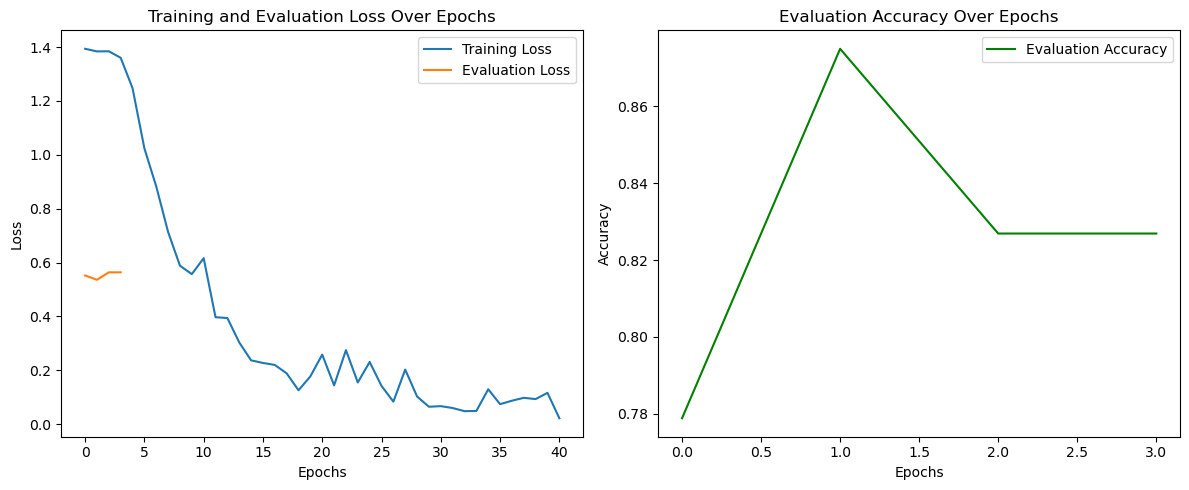

C:\Users\Rahul\AppData\Local\Temp\ipykernel_42904\2476480308.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_labels, palette="viridis")
C:\Users\Rahul\AppData\Local\Temp\ipykernel_42904\2476480308.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_labels_balanced, palette="viridis")


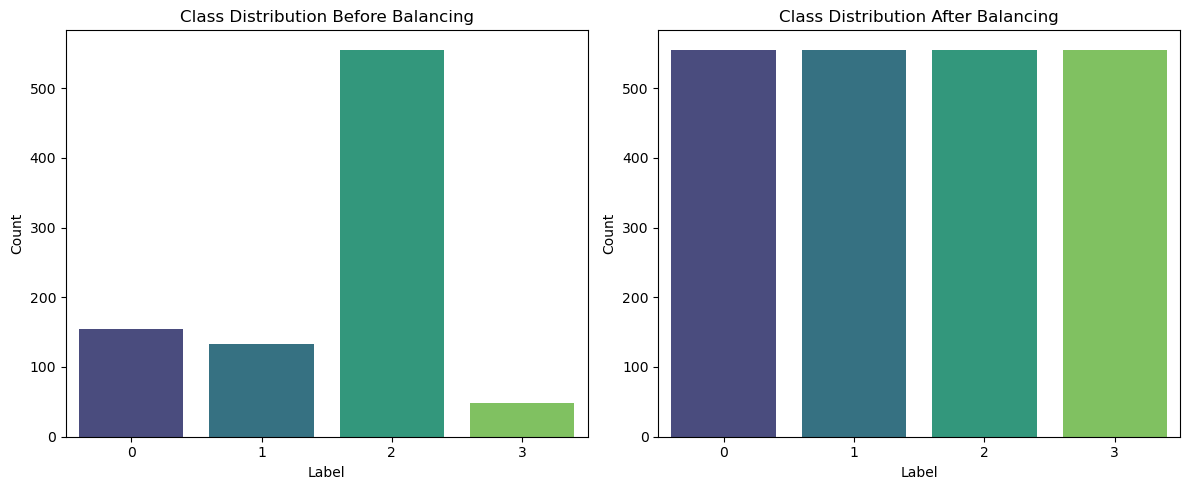

In [7]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# Load the dataset
dataset = load_dataset("poem_sentiment")

# Tokenize the dataset
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["verse_text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Split the dataset into train and test sets
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
test_dataset = tokenized_datasets["test"].shuffle(seed=42)

# Check class distribution
class_distribution = Counter(train_dataset["label"])
print("Class Distribution in Train Dataset:", class_distribution)

# Balance the dataset using oversampling
train_texts = train_dataset["verse_text"]
train_labels = train_dataset["label"]
train_texts = np.array(train_texts).reshape(-1, 1)

oversampler = RandomOverSampler(random_state=42)
train_texts_balanced, train_labels_balanced = oversampler.fit_resample(train_texts, train_labels)
train_texts_balanced = train_texts_balanced.flatten()

# Create a new balanced dataset
balanced_train_dataset = Dataset.from_dict({"verse_text": train_texts_balanced, "label": train_labels_balanced})
tokenized_train_dataset = balanced_train_dataset.map(tokenize_function, batched=True)
tokenized_train_dataset = tokenized_train_dataset.shuffle(seed=42)

# Verify class distribution
balanced_class_distribution = Counter(tokenized_train_dataset["label"])
print("Class Distribution in Balanced Train Dataset:", balanced_class_distribution)

# Load RoBERTa model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,  # Add compute_metrics function
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print("RoBERTa Evaluation Results:", results)

# Predict on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)

# Classification Report
print("\nClassification Report (RoBERTa):")
print(classification_report(test_dataset["label"], predicted_labels, target_names=["Class 0", "Class 1", "Class 2", "Class 3"]))

# Plot training and evaluation metrics
history = trainer.state.log_history

# Extract metrics
train_loss = [x["loss"] for x in history if "loss" in x and "eval_loss" not in x]
eval_loss = [x["eval_loss"] for x in history if "eval_loss" in x]
eval_accuracy = [x["eval_accuracy"] for x in history if "eval_accuracy" in x]

# Plot Training and Evaluation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Evaluation Loss")
plt.title("Training and Evaluation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot Evaluation Accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_accuracy, label="Evaluation Accuracy", color="green")
plt.title("Evaluation Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Visualize class distribution before and after balancing
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=train_labels, palette="viridis")
plt.title("Class Distribution Before Balancing")
plt.xlabel("Label")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=train_labels_balanced, palette="viridis")
plt.title("Class Distribution After Balancing")
plt.xlabel("Label")
plt.ylabel("Count")

plt.tight_layout()
plt.show()